In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir( os.path.join( '..', '..', 'notebook_format' ) )
from formats import load_style
load_style(css_style = 'custom2.css')

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size
plt.rcParams['font.size'] = 12 # and font size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,scikit-learn

Ethen 2016-10-22 11:20:25 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
scikit-learn 0.17.1


# Dimensionality Reduction

The starting point most data analysis problems is to perform some sort of exploratory data analysis on our rawa data. This step is importatnt because until we understand the basic structure of our raw data, it might be hard to know whether the data is suitable for the task at hand or even derive insight which we can share. During this exploratoy process, unsupervised methods such as dimensionality reduction and and clustering are machine learning methods that are commonly used. These methods help us identify simpler, more compact representations of the original raw data to either aid our understanding or provide useful input to other stages of analysis. Here, we'll be focusing on dimensionality reduction.

The goal of dimensionality reduction techniques, such as PCA, SVD, is to reduce complex data into a simpler, more compact representation. These simpler representations can often elucidate the underlying pattern or structure of the data.

Imagine that we're trying to understand some underlying phenomenon, and in order to do so we measure various quantities potentially related to it. If we knew exactly what to measure in advance, we might be able to find some simple relationships in our data. But we typically don't, and so we often measure anything that might be relevant, and end up having irrelevant or redundant signals in our measurement. To make this a bit more concrete, let's say we want to gather people's shoe sizes to find some trends associated it. When we go to a shoe store, we notice that the store uses two different measurements (American size and European size) and we decided measure both of them.

<img src='images/pca1.png', width='30%'>

The plotted data unsurprisingly shows a strong correlation between the two measurements (they're just sizing in different measurements). But the data doesn't lie perfectly on the $y=x$ line possibly because we made some errors during our collection process or there were some rounding issues with the number. Given this data how can we potentially find an alternative representation of the original data? To do this, one idea would be to pick a single direction in 2D, and project our points onto that single direction. But what line should we pick? One possible choice is shown below (the blue line in the plot on the left).

Representation 1           |  Representation 2
:-------------------------:|:-------------------------:
<img src='images/pca2.png', width='50%'>  |  <img src='images/pca3.png', width='50%'>

Intuitively it seems like a pretty good candidate. Looking at the projections we see that the points projected onto this line all seem close to their initial representations, which is a good sign. 

Another way to think about this is that, in order to identify patterns in our data, we often look for variation across observations. So it seems reasonable to find a succinct representation that best captures variation in our initial data. In particular, we could look to explain our data via it's maximal directions of variance. Consider the direction shown by the arrow on the right-side plot above, we see that the variation is quite large in this direction compared to other direction.

We can formalize this via the notion of projection error. Specifically, PCA's goal is to minimize the Euclidean distances between our original points and their projections. Looking back at the left plot above, PCA aims to find the projections that minimize the length of the black lines between the original points in red, and the projected points in blue. 

In a nutshell, PCA aims to find the directions (or so called the principal components) of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace to increase computational efficiency, while retaining most of the information.

## PCA

The general framework for conducting PCA is as follows:

- Standardize the data.
- Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix.
- Sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace.
- Projection onto the new feature space. During this step we will take the top $k$ eigenvectors and use it to transform the original dataset $X$ to obtain a k-dimensional feature subspace $X'$.

For the following tutorial, we will be working with the famous "Iris" dataset. The iris dataset is a 150×4 matrix where the columns are the different features (sepal length in cm, sepal width in cm, petal length in cm, petal width in cm) and every every row represents a separate flower sample. The three classes in the Iris dataset are: Iris-setosa (n=50), Iris-versicolor (n=50), Iris-virginica (n=50).

To get a feeling for how the 3 different flower classes are distributes along the 4 different features, let us visualize them via histograms.

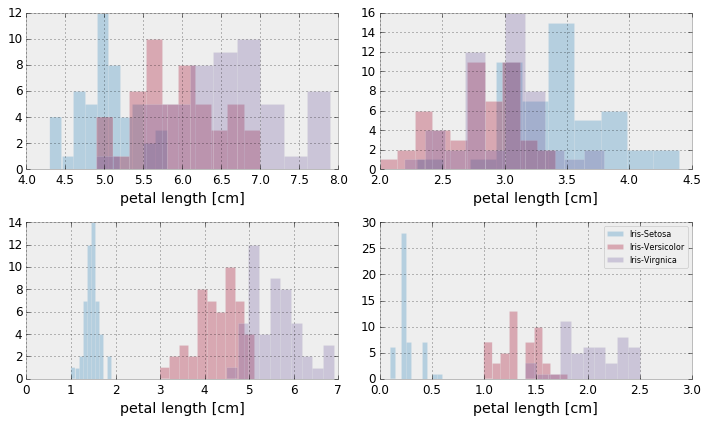

In [3]:
iris = load_iris()
X = iris['data']
y = iris['target']

label_dict = {0: 'Iris-Setosa',
              1: 'Iris-Versicolor',
              2: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

plt.figure(figsize = (10, 6))
for feature in range(len(feature_dict)):
    plt.subplot(2, 2, feature + 1)
    for index, label in label_dict.items():
        plt.hist( X[y == index, feature], label = label,
                  bins = 10, alpha = 0.3 )
        plt.xlabel(feature_dict[index])
        
plt.legend(loc = 'upper right', fancybox = True, fontsize = 8)
plt.tight_layout()
plt.show()

### Standardize

In general, it's important to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially if it was measured on different scales.

In [4]:
X_std = StandardScaler().fit_transform(X)

### Eigendecomposition - Computing Eigenvectors and Eigenvalues

The eigenvectors and eigenvalues of a covariance matrix is the core of PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix $\Sigma$, which is a d x d matrix where each element represents the covariance between two features. The covariance between two features $x_j$ and $x_k$ is calculated as follows:

$$\sigma_{jk} = \frac{1}{n-1} \sum_{i=1}^{n} \left( x_{ij} - \bar{x}_j \right) \left( x_{ik} - \bar{x}_k \right).$$

Where $\bar{x}_j$ is simply the mean of vector (feature) $\bar{x}_j = \sum \limits_{i=1}^n x_{ij}$.

We can also summarize the calculation of the covariance matrix via the following matrix equation: 

$$\Sigma = \frac{1}{n-1} \big( (X - \bar{x})^T( X - \bar{x}) \big)$$

In [5]:
vec_mean = np.mean(X_std, axis = 0)
vec_diff = X_std - vec_mean
cov_mat  = (vec_diff).T.dot(vec_diff) / (X_std.shape[0] - 1)
print( 'Covariance matrix \n {}'.format(cov_mat) )

# equivalently, we could have used the np.cov function:
# since each row represents a variable for np.cov,
# we'll need to transpose the matrix
print( 'NumPy covariance matrix: \n {}'.format(np.cov(X_std.T)) )

Covariance matrix 
 [[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]
NumPy covariance matrix: 
 [[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


After obtaining the covariance matrix, we perform an eigendecomposition on it to obtain the eigenvalues and eigenvectors. The notion of eigendecomposition is basically trying to solve the equation:

$$Ax=\lambda x$$

In our case, $A$ is our covariance matrix $\pmb\Sigma$; $\pmb x$ is our eigenvector and $\pmb \lambda$ is our eigenvalue.

In [6]:
# since computing this by hand can be quite tedious
# we'll simply use the pre-implemented function
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print( 'Eigenvectors \n%s' % eig_vecs )
print( '\nEigenvalues \n%s' % eig_vals )

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[ 2.93035378  0.92740362  0.14834223  0.02074601]


### Choosing Top K Eigenvectors

Recall that the typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace. In order to decide which eigenvector(s) can dropped without losing too much information for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues. The idea is: eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data and those are the ones can be dropped. In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top $k$ eigenvectors.

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called “explained variance,” which can be calculated from the eigenvalues. The explained variance tells us how much extra information (variance) does each of the principal components contribute.

[ 0.72770452  0.95800975  0.99484807  1.        ]


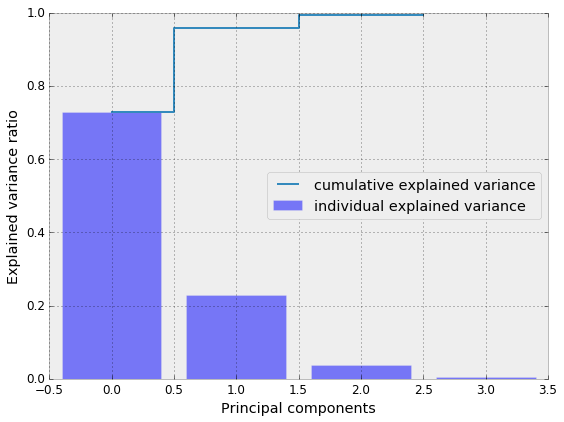

In [7]:
eig_vals_total = sum(eig_vals)
var_exp = eig_vals / eig_vals_total
var_exp_cum = np.cumsum(var_exp)
print(var_exp_cum)

plt.bar(range(4), var_exp, alpha = 0.5, align = 'center',
        label='individual explained variance')
plt.step(range(4), var_exp_cum, where = 'mid',
         label = 'cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

The plot above clearly shows that most of the variance (72.77% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (23.03%) while the third and fourth principal components can safely be dropped without losing to much information. Together, the first two principal components explains 95.8% of the variance. Or in other words, it contain 95.8% of the information (95% or 99% are comon threshold that people use).

### Projection Onto the New Feature Space

In the last step, we will use the 4×2-dimensional eigenvectors to transform our samples onto the new subspace via the equation Y=X×W, where Y will be our 150×2 matrix of transformed samples (we reduce the dimension from the original 4 down to 2).

In [8]:
def plot_iris_pca(X_pca):
    """a scatter plot of the 2-dimensional iris data"""
    markers = 's', 'x', 'o'
    colors  = 'blue', 'red', 'green'
    for l, m, c in zip( np.unique(y), markers, colors ):
        subset = X_pca[y == l]
        plt.scatter( subset[:, 0], subset[:, 1], s = 30,
                     c = c, label = l, marker = m )

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    # plt.savefig('./figures/pca2.png', dpi = 300)
    plt.show()

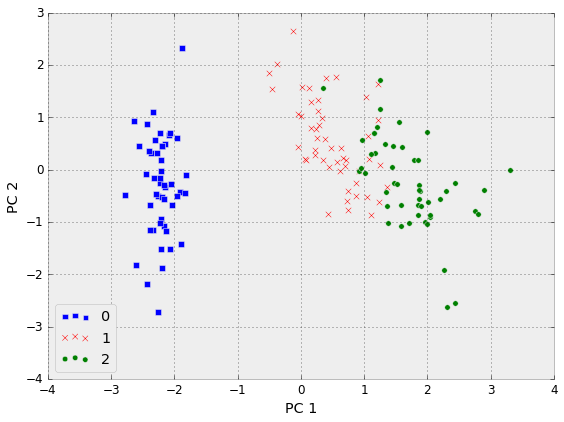

In [9]:
X_std_pca = X_std.dot(eig_vecs[:, 0:2])
plot_iris_pca(X_std_pca)

For educational purposes, we went a long way to apply the PCA to the Iris dataset. But luckily, there are lots of open-source library which we can use. Such as scikit-learn:

[ 0.72770452  0.23030523]


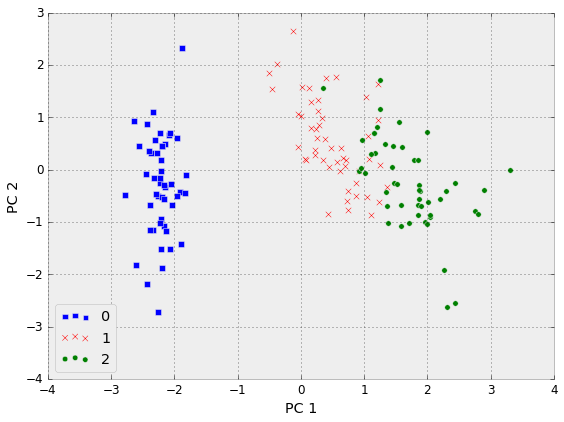

In [10]:
pca = PCA(n_components = 2)
X_std_pca = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)
plot_iris_pca(X_std_pca)

## Reference

- [Youtube: Dimensionality Reduction](https://www.youtube.com/playlist?list=PLnnr1O8OWc6aVexn2BY0qjklobY6TUEIy)
- [Blog: Principal Component Analysis in 3 Simple Steps](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)